In [495]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [496]:
from PIL import Image
import pytesseract

In [497]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from umap import UMAP 

In [498]:
# from IPython.display import Image as image
# image(filename='pics/test1.jpg')

In [499]:
raws = pytesseract.image_to_boxes(Image.open('pics/image4.png')).split('\n')[:-1]
matrix = [[raw[0]] + [int(el) for el in raw.split(' ')[1:-1]] for raw in raws]

In [500]:
dataset = (pd.DataFrame(np.array(matrix)).rename({
    0: 'char',
    1: 'x1',
    2: 'y1',
    3: 'x2',
    4: 'y2' 
    }, axis=1)
    .astype({
            'char': str,
            'x1': int,
            'x2': int,
            'y1': int,
            'y2': int,
    }))

In [501]:
dataset['x_centroid'] = dataset['x1'] + (dataset['x2'] - dataset['x1'] /2)
dataset['y_centroid'] = dataset['y1'] + (dataset['y2'] - dataset['y1'] /2)
dataset['zero'] = 0
dataset['shape'] = abs(dataset['y2'] - dataset['y1']) * abs(dataset['x2'] - dataset['x1'])

In [502]:
slice_list = [i for i in range(1, 5)]

In [503]:
from scipy.spatial import distance_matrix

l2_distance = distance_matrix(dataset[['x_centroid', 'y_centroid']], dataset[['x_centroid', 'y_centroid']])

x_matrix = distance_matrix(dataset[['x_centroid', 'zero']], dataset[['x_centroid', 'zero']])
x_distances = x_matrix.flatten()

y_matrix = distance_matrix(dataset[['y_centroid', 'zero']], dataset[['y_centroid', 'zero']])
y_distances = y_matrix.flatten()

x_mean_dist = np.mean(x_distances)
y_mean_dist = np.mean(y_distances)

x_std_dist = np.std(x_distances)
y_std_dist = np.std(y_distances)

l2_matrix_n_neigh = np.sort(l2_distance, axis=0).take(slice_list, axis=0).flatten()

In [504]:
l2_matrix_n_neigh

array([ 4.        ,  3.60555128,  3.60555128, ..., 13.58307771,
       18.20027472, 19.00657781])

In [505]:
epsilon = np.percentile(l2_matrix_n_neigh, 90)

In [506]:
import numba

@numba.njit()
def custom_metric(a,b):
    return (np.exp(np.abs(a[0] - b[0]) / x_std_dist) / x_mean_dist)**2 + (np.exp(np.abs(a[1] - b[1]) / y_std_dist) / y_mean_dist)**2

In [507]:
clustered = dataset.copy()

reducer = UMAP(n_neighbors=10, min_dist=0.0, metric=custom_metric)
embedding = reducer.fit_transform(dataset[['x_centroid', 'y_centroid']])

/home/denissimo/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1727: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


<AxesSubplot:>

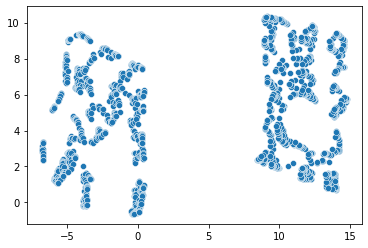

In [508]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:,1])

In [509]:
clustering = DBSCAN(eps=2, min_samples=15).fit(embedding)
clustered['cluster'] = clustering.labels_

In [510]:
cluster_order = clustered.groupby('cluster').agg({'x1': np.mean, 'y1': np.mean}).sort_values(['y1', 'x1'], ascending=False).reset_index().reset_index()[['index', 'cluster']]
clustered = clustered.merge(cluster_order.rename({'index': 'cluster_order'}, axis=1), on='cluster', how='right')

2

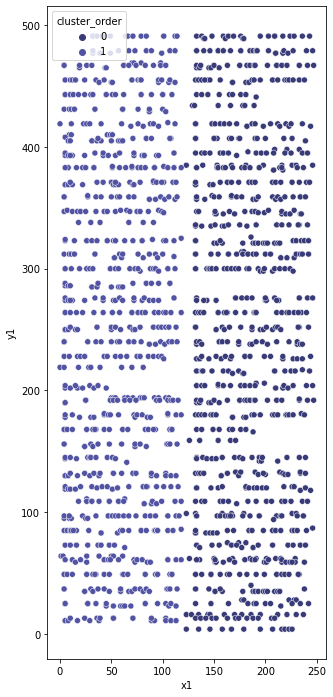

In [511]:
_, axs = plt.subplots(figsize=(5, 12))

sns.scatterplot(data=clustered, x='x1', y='y1', hue='cluster_order', ax=axs, palette='tab20b')

clustered.cluster_order.nunique()

In [512]:
from hdbscan import HDBSCAN

In [513]:
clustering = HDBSCAN(algorithm='best', metric='seuclidean', min_cluster_size=10, min_samples=8, p=None)
clustered = clustered.merge(cluster_order.rename({'index': 'cluster_order'}, axis=1), on='cluster', how='right')

In [514]:
cluster_order = clustered.groupby('cluster').agg({'x1': np.mean, 'y1': np.mean}).sort_values(['y1', 'x1'], ascending=False).reset_index().reset_index()[['index', 'cluster']]
clustered = clustered.merge(cluster_order.rename({'index': 'cluster_order'}, axis=1), on='cluster', how='right')

2

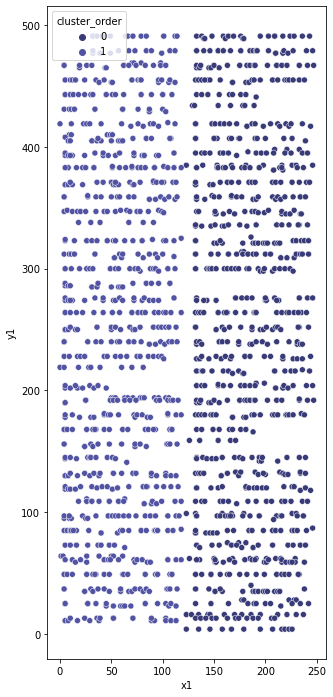

In [515]:
_, axs = plt.subplots(figsize=(5, 12))

sns.scatterplot(data=clustered, x='x1', y='y1', hue='cluster_order', ax=axs, palette='tab20b')

clustered.cluster_order.nunique()

In [516]:
clustering = DBSCAN(eps=epsilon, min_samples=15).fit(dataset[['x_centroid', 'y_centroid']])
clustered['cluster'] = clustering.labels_

In [519]:
cluster_order = clustered.groupby('cluster').agg({'x1': np.mean, 'y1': np.mean}).sort_values(['y1', 'x1'], ascending=False).reset_index().reset_index()[['index', 'cluster']]
clustered = clustered.merge(cluster_order.rename({'index': 'cluster_order'}, axis=1), on='cluster', how='right')

1

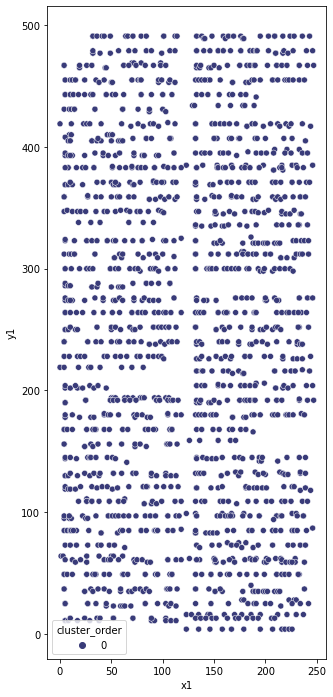

In [520]:
_, axs = plt.subplots(figsize=(5, 12))

sns.scatterplot(data=clustered, x='x1', y='y1', hue='cluster_order', ax=axs, palette='tab20b')

clustered.cluster_order.nunique()